In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aging.plotting import figure, legend, format_plots
from tqdm.auto import tqdm

In [2]:
format_plots()

In [3]:
df_path = '/n/groups/datta/win/longtogeny/data/ontogeny/version_09/ontogeny_males_syllable_df_v00.parquet'
df = pd.read_parquet(df_path)
df_path = '/n/groups/datta/win/longtogeny/data/ontogeny/version_09/dana_ontogeny_males_syllable_df_v00.parquet'
df = pd.concat([df, pd.read_parquet(df_path)])

In [4]:
df['age'].unique()

array([ 12,  90, 103,  16,  78,  40,  52,  28,  32,  72,  48,   4,  64,
        68,  44,   8,  20,  84,  80,  36,  60,  56,   9,   7,   3,   5,
        35,  24])

In [5]:
out = {}
for (age, mouse, uuid), _df in tqdm(df.groupby(['age', 'subject_name', 'uuid'])):
    height = _df['height_ave_mm'].rolling(11, center=True).median()
    demeaned_height = height - height.quantile(0.1)
    # demeaned_height = height - height.median()
    thresh = demeaned_height.std() * 2
    mask = demeaned_height > thresh
    rear_counts = (mask.astype(int).diff() == 1).sum() / (len(mask) / 30)
    out[(age, mouse, uuid)] = {'rear_counts': rear_counts, 'area': _df.loc[~mask, 'area_px'].median(), 'recon_area': _df.loc[~mask, 'recon_area'].median()}

  0%|          | 0/562 [00:00<?, ?it/s]

In [6]:
out_df = pd.DataFrame(out).T
out_df.index.names = ['age', 'mouse', 'uuid']
out_df = out_df.reset_index()

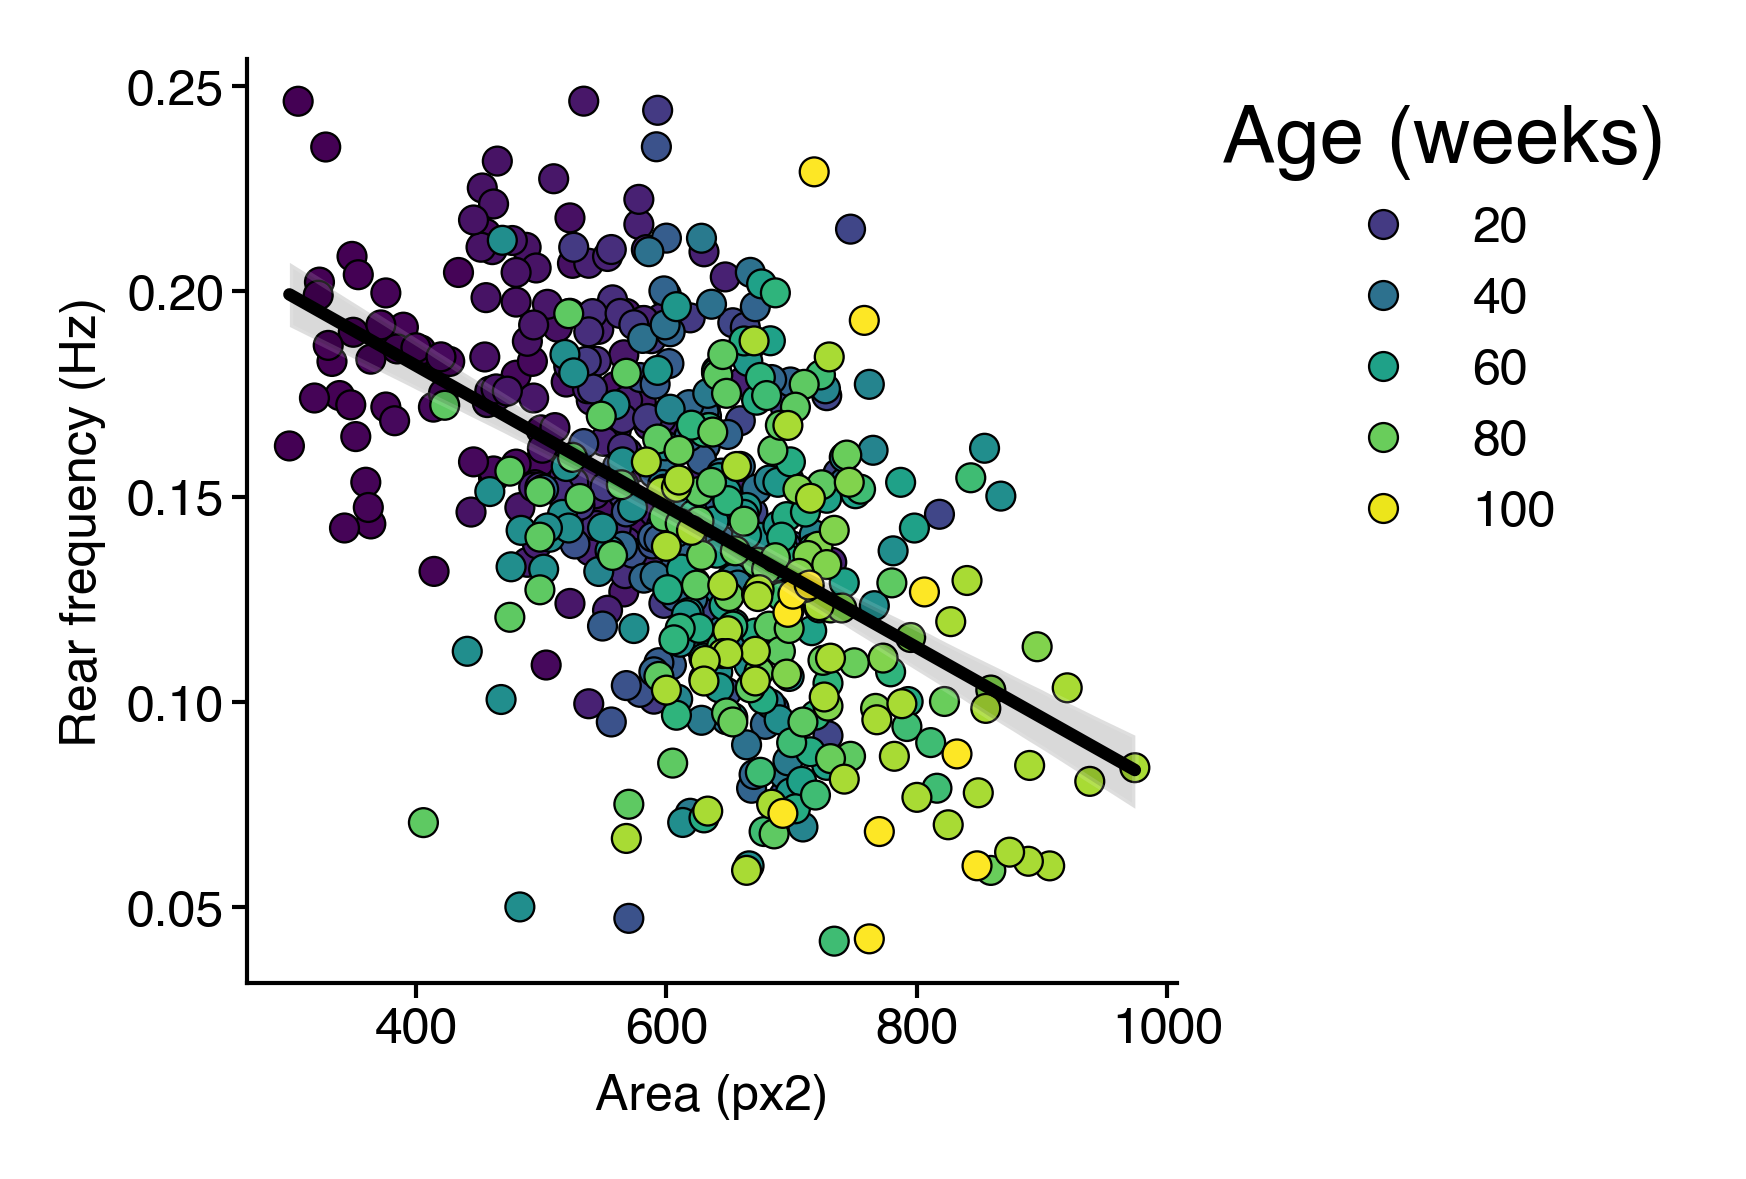

In [7]:
figure(2, 2)
ax = sns.scatterplot(data=out_df, x='area', y='rear_counts', hue='age', palette='viridis', s=12, edgecolor='k')
ax = sns.regplot(data=out_df, x='area', y='rear_counts', scatter=False, ax=ax, color='k')
ax.set(ylabel="Rear frequency (Hz)", xlabel="Area (px2)")
sns.despine()
legend(title='Age (weeks)')

In [8]:
out_df[['rear_counts', 'area']].corr()

,rear_counts,area
rear_counts,1.00000,-0.49938
area,-0.49938,1.00000


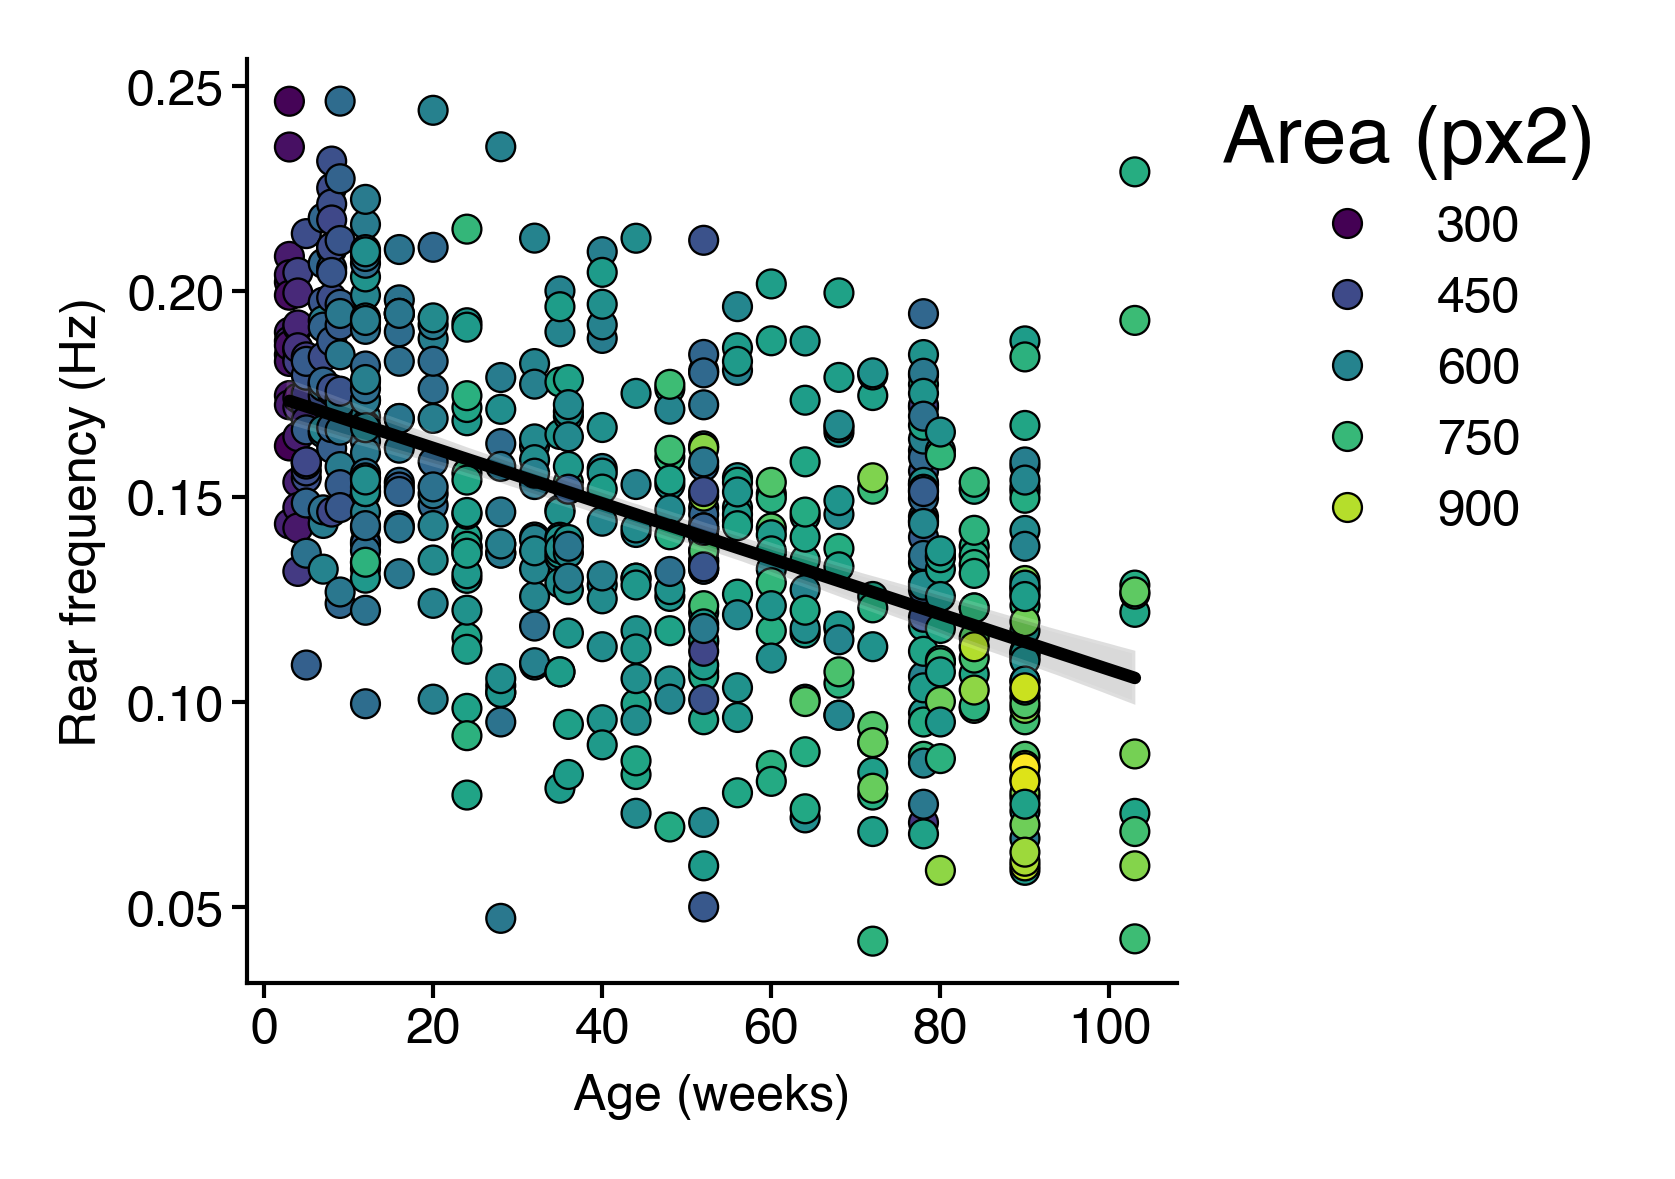

In [9]:
figure(2, 2)
ax = sns.scatterplot(data=out_df, x='age', y='rear_counts', hue='area', palette='viridis', s=12, edgecolor='k')
ax = sns.regplot(data=out_df, x='age', y='rear_counts', scatter=False, ax=ax, color='k')
ax.set(ylabel="Rear frequency (Hz)", xlabel="Age (weeks)")
sns.despine()
legend(title='Area (px2)')

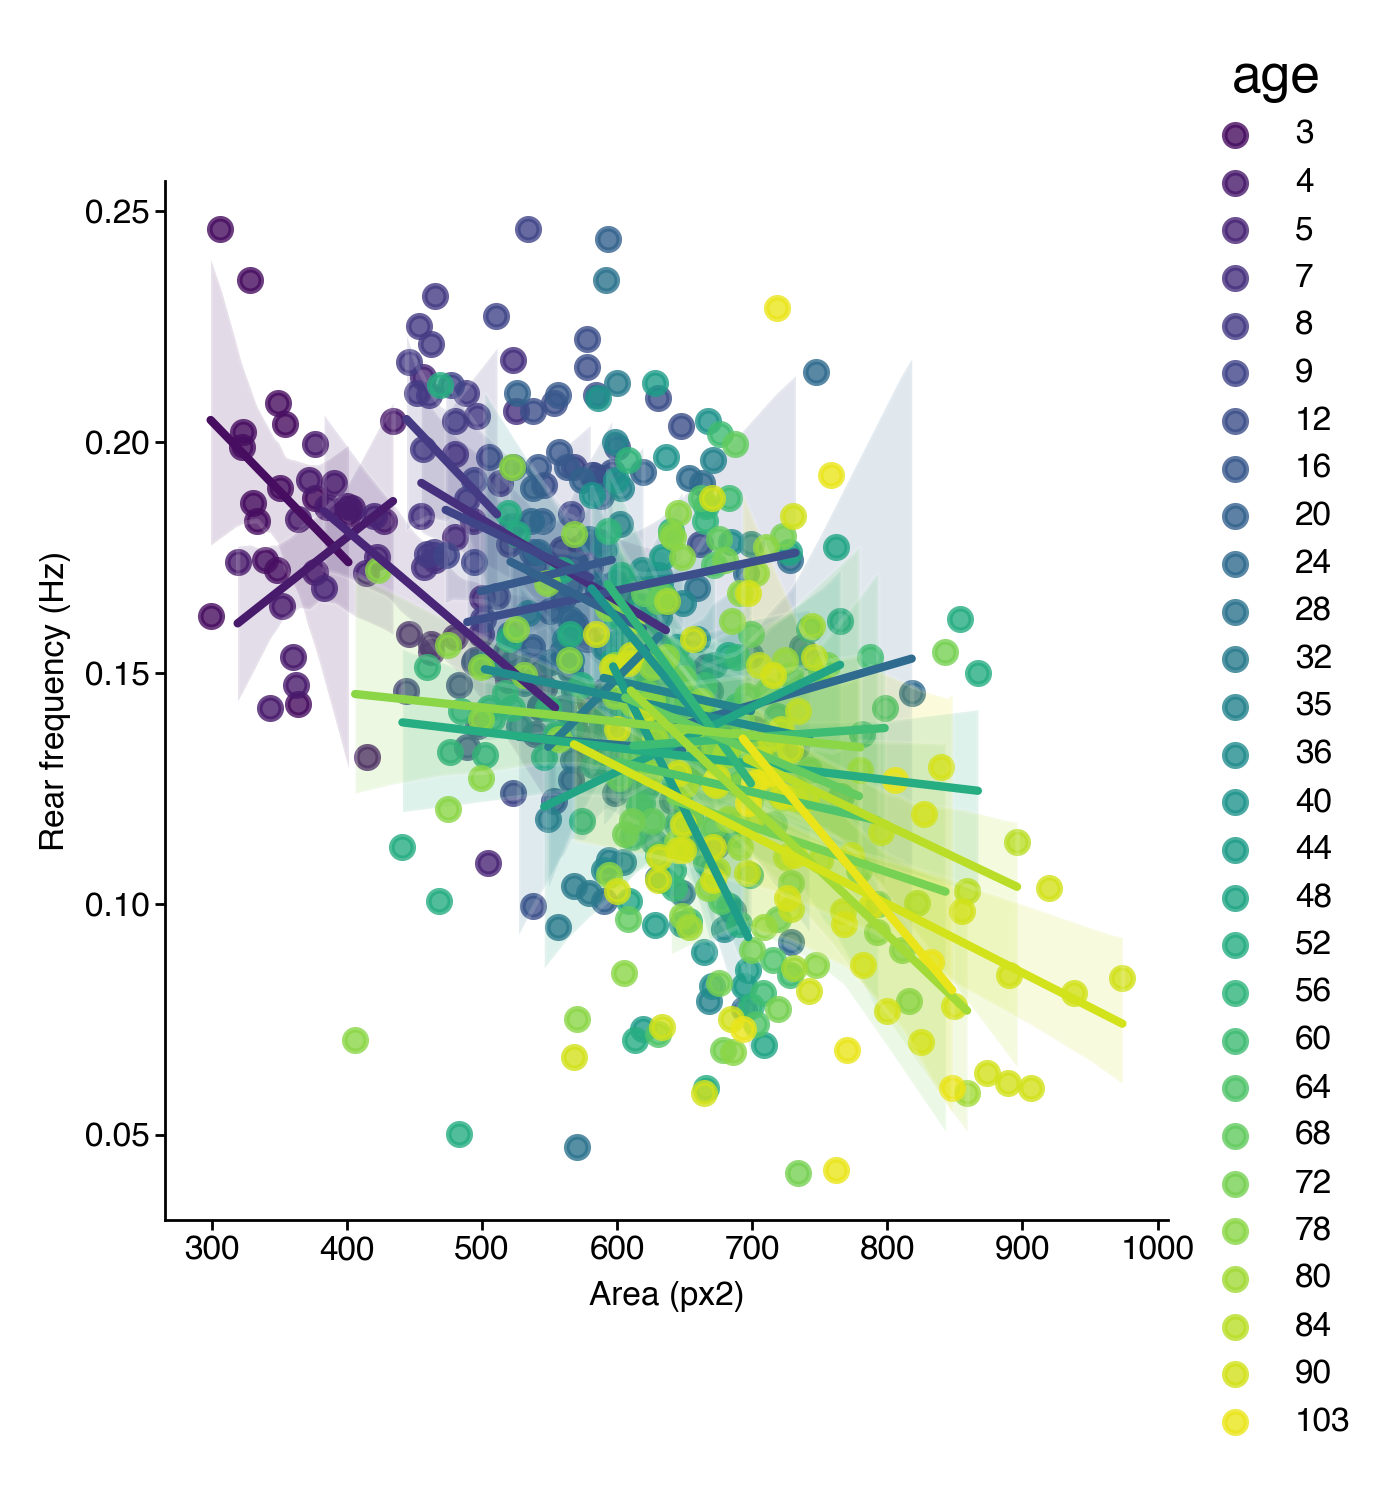

In [10]:
ax = sns.lmplot(data=out_df, x='area', y='rear_counts', hue='age', palette='viridis', height=3, scatter_kws={'s': 15}, n_boot=100)
ax.set(ylabel="Rear frequency (Hz)", xlabel="Area (px2)")
sns.despine()

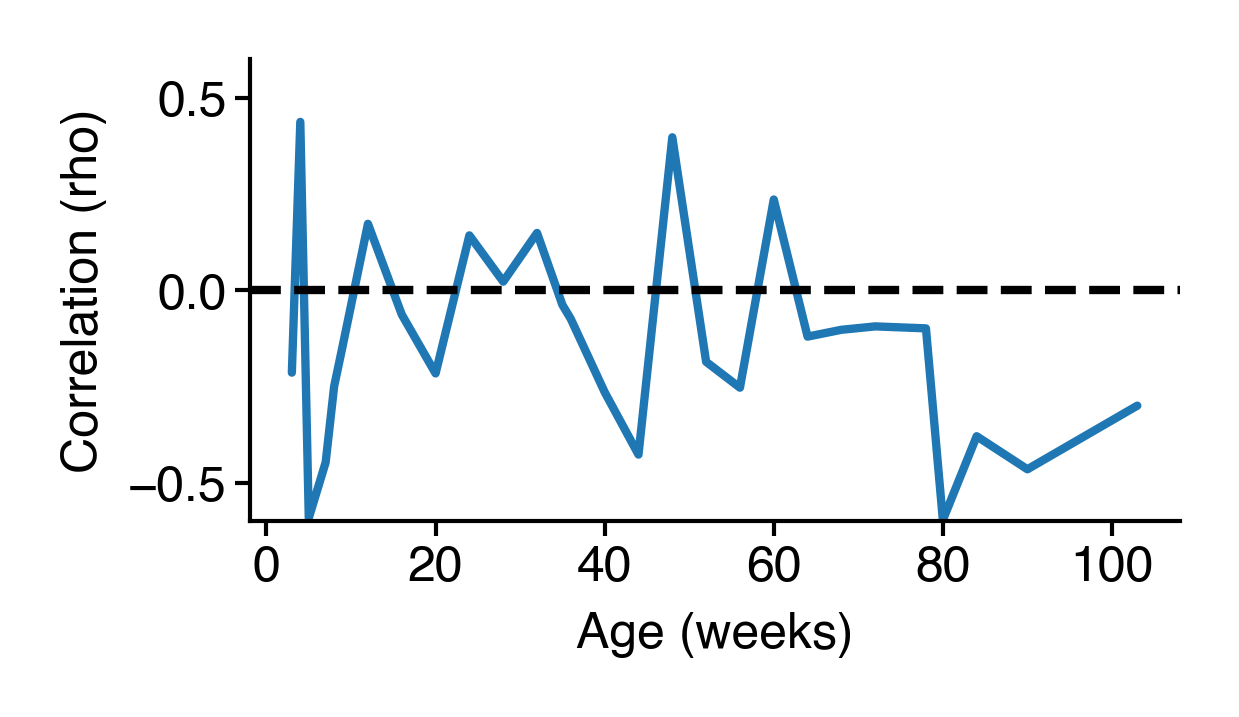

In [11]:
corr = out_df.groupby('age')[['rear_counts', 'area']].corr(method='spearman').loc[:, 'area']
corr = corr.loc[pd.IndexSlice[:, 'rear_counts']]
fig = figure(2, 1)
ax = corr.plot()
ax.axhline(0, linestyle='--', color='k')
ax.set(ylabel='Correlation (rho)', xlabel='Age (weeks)', ylim=(-0.6, 0.6))
sns.despine()

### Set up linear models predicting rearing frequency from behavior

In [8]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit, KFold, cross_validate
from sklearn.pipeline import make_pipeline

In [9]:
pipeline = make_pipeline(StandardScaler(), Lasso(alpha=0.15))
shuffler = ShuffleSplit(n_splits=12, test_size=0.25, random_state=0)

In [11]:
X = out_df[['area']]
Y = out_df['rear_counts']
Y = StandardScaler().fit_transform(Y.values.reshape(-1, 1)).ravel()
scores = cross_val_score(pipeline, X, Y, cv=shuffler, scoring='r2')
np.mean(scores)

0.21224351534073746

In [12]:
X = out_df[['age']]
Y = out_df['rear_counts']
Y = StandardScaler().fit_transform(Y.values.reshape(-1, 1)).ravel()
scores = cross_val_score(pipeline, X, Y, cv=shuffler, scoring='r2')
np.mean(scores)

0.23698138828854165

In [13]:
X = out_df[['recon_area']]
Y = out_df['rear_counts']
Y = StandardScaler().fit_transform(Y.values.reshape(-1, 1)).ravel()
scores = cross_val_score(pipeline, X, Y, cv=shuffler, scoring='r2')
np.mean(scores)

-0.005478579328395923

In [14]:
X = out_df[['age', 'area', 'recon_area']].to_numpy()
X = np.hstack([X, X[:, 0:1] * X[:, 1:2], X[:, 0:1] * X[:, 2:3]])
Y = out_df['rear_counts']
Y = StandardScaler().fit_transform(Y.values.reshape(-1, 1)).ravel()
out = cross_validate(pipeline, X, Y, cv=shuffler, scoring='r2', return_estimator=True)
np.mean(out['test_score'])

0.295446151923221

/tmp/ipykernel_30711/604472168.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(ylabel="Coefficient", xlabel="Feature", xticklabels=['Age', 'Area', 'Recon Area', 'Age * Area', 'Age * Recon Area'])


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Age'),
  Text(1, 0, 'Area'),
  Text(2, 0, 'Recon Area'),
  Text(3, 0, 'Age * Area'),
  Text(4, 0, 'Age * Recon Area')])

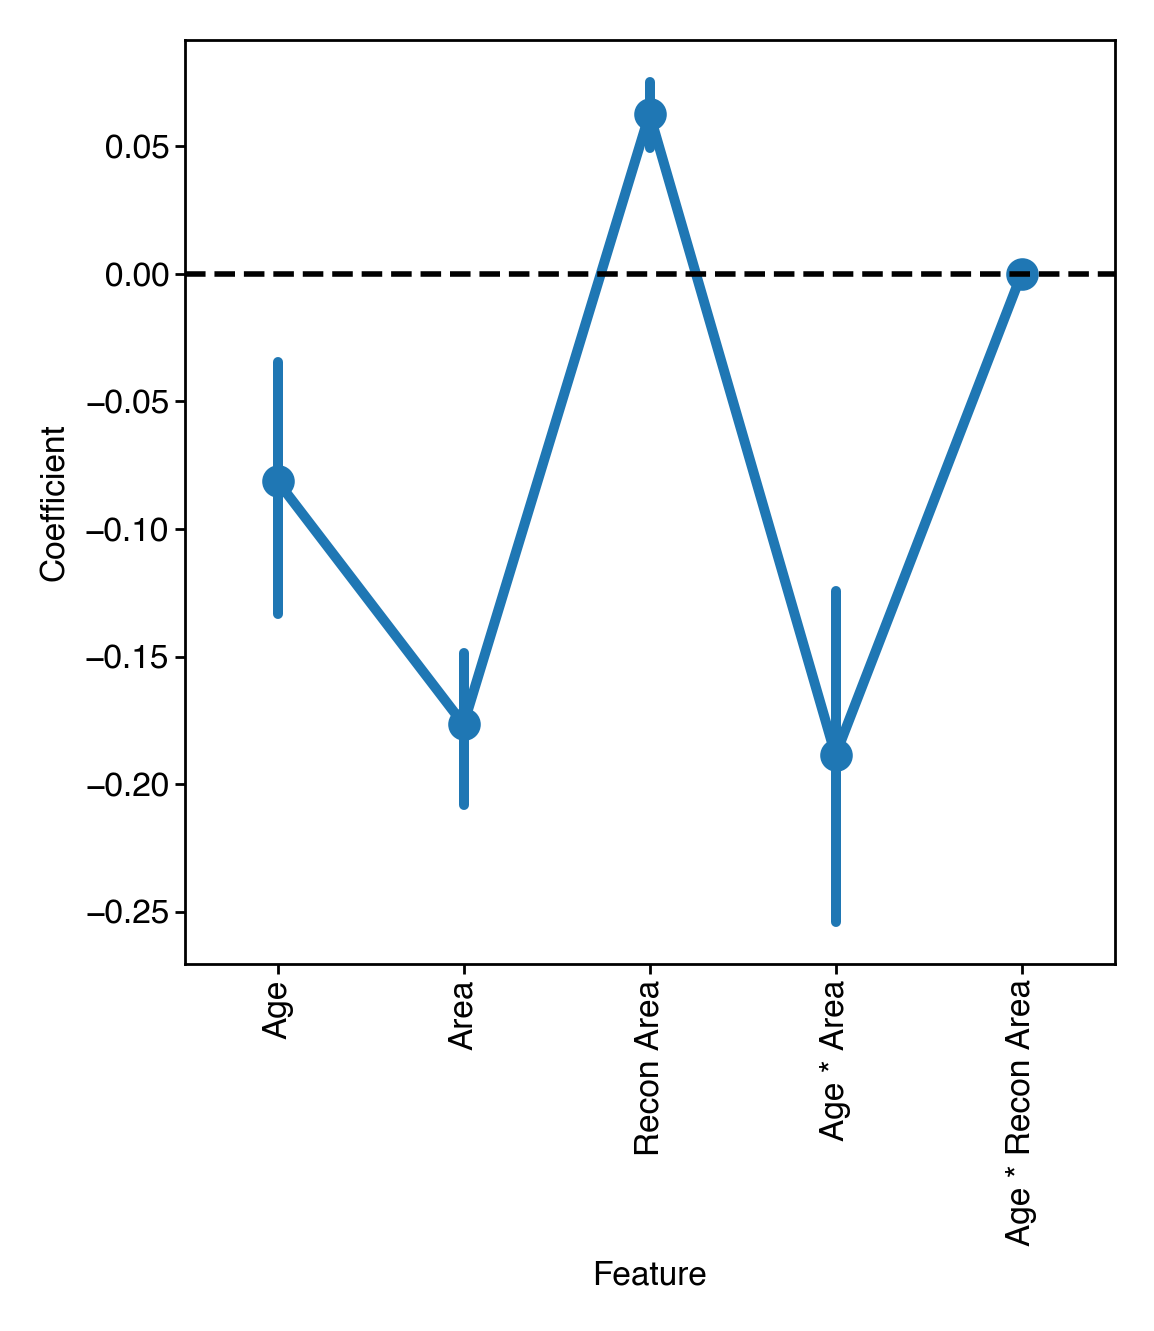

In [15]:
weights = np.array([est.named_steps['lasso'].coef_ for est in out['estimator']])
ax = sns.pointplot(weights)
ax.axhline(0, color='k', linestyle='--')
ax.set(ylabel="Coefficient", xlabel="Feature", xticklabels=['Age', 'Area', 'Recon Area', 'Age * Area', 'Age * Recon Area'])
plt.xticks(rotation=90)

In [115]:
X = out_df[['age', 'area']].to_numpy()
X = np.hstack([X, X[:, 0:1] * X[:, 1:2]])
Y = out_df['rear_counts']
Y = StandardScaler().fit_transform(Y.values.reshape(-1, 1)).ravel()
out = cross_validate(pipeline, X, Y, cv=shuffler, scoring='r2', return_estimator=True)
np.mean(out['test_score'])

0.26841250194598626

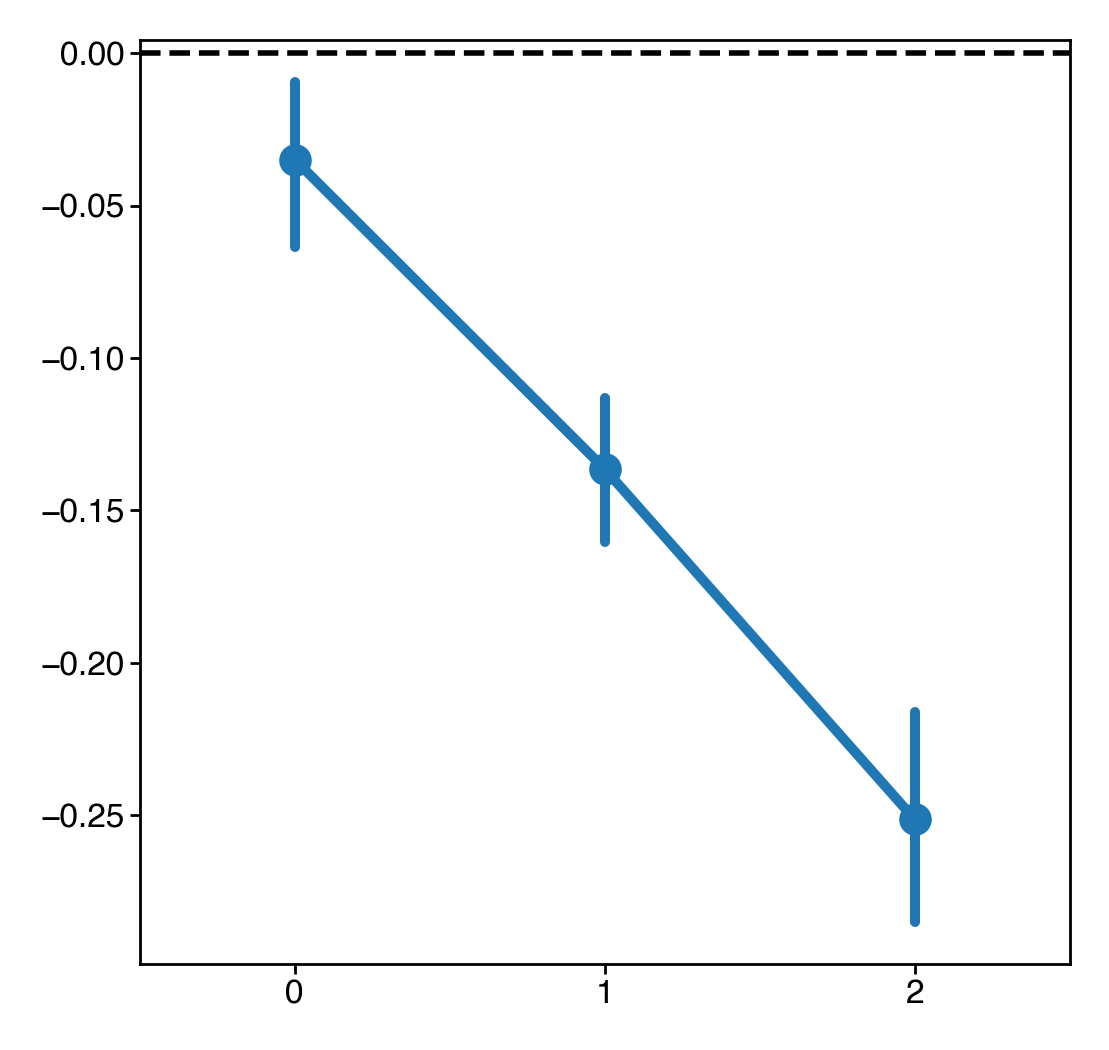

In [116]:
weights = np.array([est.named_steps['lasso'].coef_ for est in out['estimator']])
ax = sns.pointplot(weights)
ax.axhline(0, color='k', linestyle='--')
# plt.plot(weights.T)

## Repeat for longtogeny

In [117]:
df_path = '/n/groups/datta/win/longtogeny/data/ontogeny/version_09/longtogeny_males_syllable_df_v00.parquet'
df = pd.read_parquet(df_path)

In [118]:
df['age_cut'] = pd.qcut(df['age'], 30, labels=False)
df['age_cut'] = df['age_cut'].map(df.groupby('age_cut')['age'].mean())

In [119]:
out = {}
for (age, mouse, session, uuid), _df in tqdm(df.groupby(['age_cut', 'subject_name', 'session_name', 'uuid'], sort=False)):
    height = _df['height_ave_mm'].rolling(11, center=True).median()
    demeaned_height = height - height.quantile(0.1)
    # demeaned_height = height - height.median()
    thresh = demeaned_height.std() * 2
    mask = demeaned_height > thresh
    rear_counts = (mask.astype(int).diff() == 1).sum() / (len(mask) / 30)
    out[(age, mouse, session, uuid)] = {'rear_counts': rear_counts, 'area': _df.loc[~mask, 'area_px'].median(), 'recon_area': _df.loc[~mask, 'recon_area'].median()}
out_df = pd.DataFrame(out).T
out_df.index.names = ['age', 'mouse', 'session', 'uuid']
out_df = out_df.reset_index()

  0%|          | 0/1207 [00:00<?, ?it/s]

In [120]:
out_df = out_df.astype(
    {"age": "float[pyarrow]", "rear_counts": "float[pyarrow]", "area": "float[pyarrow]"}
).astype({"age": "float", "rear_counts": "float", "area": "float"})
out_df['age'] = out_df['age'].transform(lambda x: np.round(x, 1))
out_df = out_df.query('area > 150')

In [89]:
out_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1179 entries, 0 to 1206
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1179 non-null   float64
 1   mouse        1179 non-null   object 
 2   session      1179 non-null   object 
 3   uuid         1179 non-null   object 
 4   rear_counts  1179 non-null   float64
 5   area         1179 non-null   float64
dtypes: float64(3), object(3)
memory usage: 64.5+ KB


In [94]:
out_df.head()

,age,mouse,session,uuid,rear_counts,area
0,115.4,Long2_R_01,long_M_01,6f88ede3-8837-4d3e-a51a-1aa70e6c2bb4,0.060053,807.0
1,4.1,03_01_028,008,63c00b73-1840-4ac8-97ba-15c1c74d8737,0.226931,318.0
2,69.5,01_04_215,215,fa0391a5-c91f-4384-bdef-91cb6aeec1a8,0.187662,701.0
3,61.3,02_02_209,209,b4516bf6-a4c6-4c8a-913b-94dcef5b7247,0.106791,888.0
4,61.3,04_02_210,210,fa07bb54-bba0-46f1-b46a-86323d7e4908,0.129321,1107.0


In [95]:
out_df['session'].unique()

array(['long_M_01', '008', '215', '209', '210', '200', '006', '005',
       '208', 'long_M_03', '207', 'long_M_02', '047', '201', '211', '214',
       '206', '051', '217', '202', '205', 'Long_M_01', '203', '213',
       '038', '212', '044', '035', '204', '099', '011', '120', '002',
       '104', '300', '007', '080', '131', '216', '041', '040', '004',
       '071', '046', '085', '037', '110', '070', '100', '032', '060',
       '103', '042', '089', '009', '101', '036', '102', '048', '043',
       '003', '045', '012', '031', '105', '090', '001', 'aging_o_3',
       '015', 'nor_03', '010', '039', '050', 'long_M_09', 'long_M_08',
       'long_M_13', 'long_M_07', 'long_M_14', 'long_M_11', 'long_M_12',
       'long_M_05', 'long_M_10'], dtype=object)

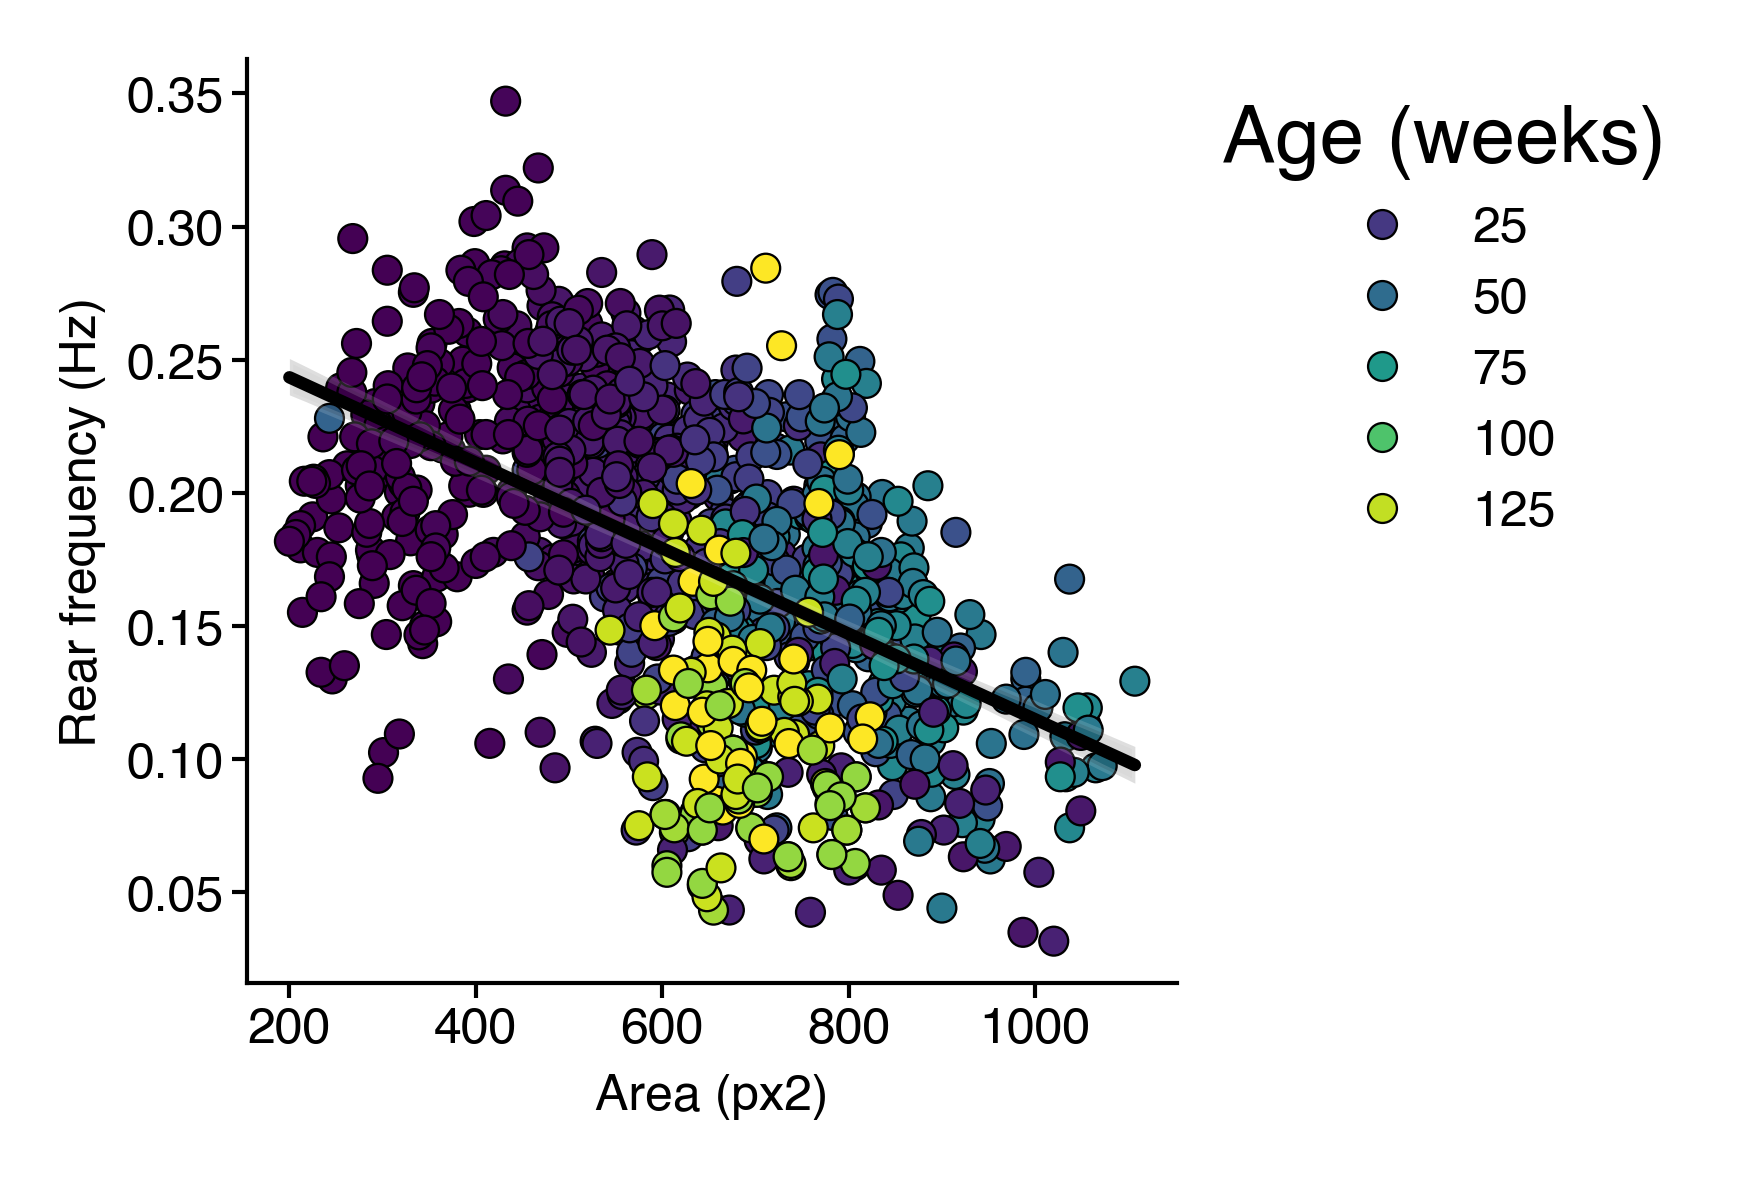

In [90]:
figure(2, 2)
ax = sns.scatterplot(data=out_df, x='area', y='rear_counts', hue='age', palette='viridis', s=12, edgecolor='k')
ax = sns.regplot(data=out_df, x='area', y='rear_counts', scatter=False, ax=ax, color='k')
ax.set(ylabel="Rear frequency (Hz)", xlabel="Area (px2)")
sns.despine()
legend(title='Age (weeks)')

In [91]:
out_df[['rear_counts', 'area']].corr(method='spearman')

,rear_counts,area
rear_counts,1.000000,-0.548295
area,-0.548295,1.000000


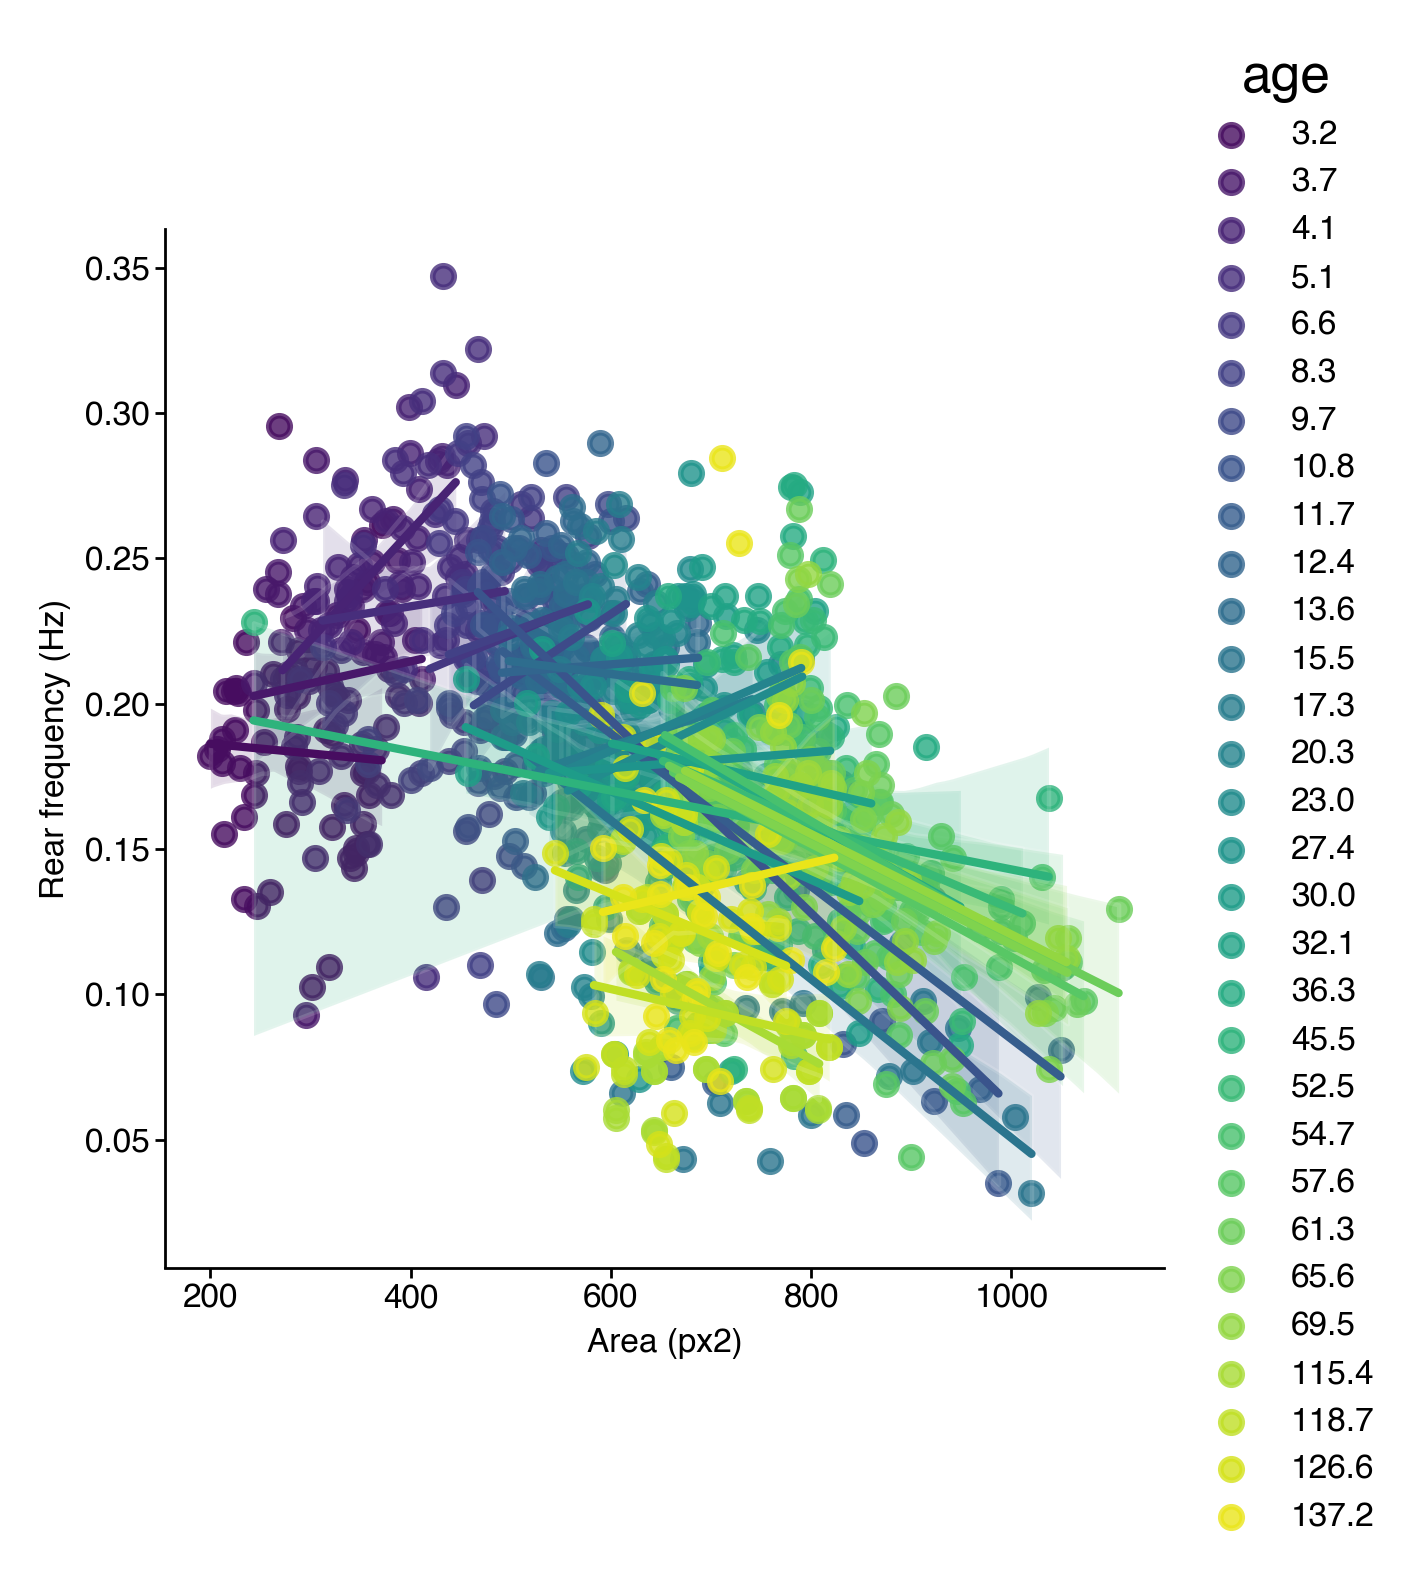

In [92]:
ax = sns.lmplot(data=out_df, x='area', y='rear_counts', hue='age', palette='viridis', height=3, scatter_kws={'s': 15}, n_boot=100)
ax.set(ylabel="Rear frequency (Hz)", xlabel="Area (px2)")
sns.despine()

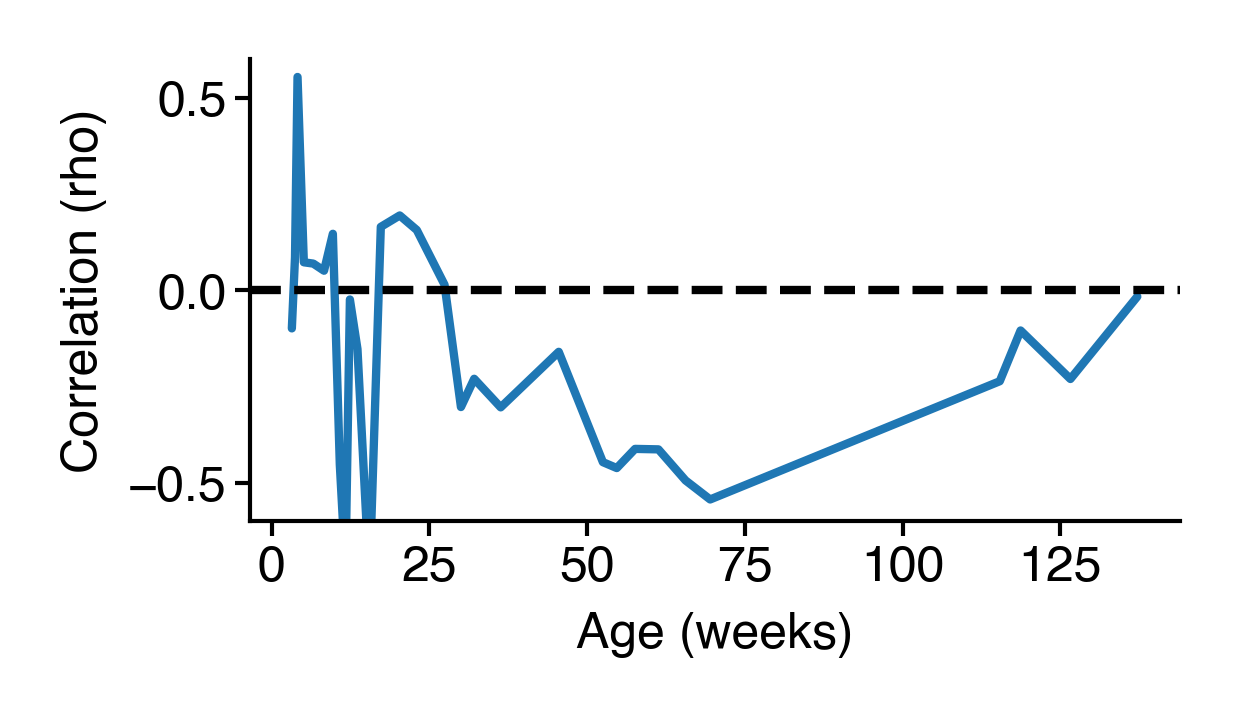

In [93]:
corr = out_df.groupby('age')[['rear_counts', 'area']].corr(method='spearman').loc[:, 'area']
corr = corr.loc[pd.IndexSlice[:, 'rear_counts']]
fig = figure(2, 1)
ax = corr.plot()
ax.axhline(0, linestyle='--', color='k')
ax.set(ylabel='Correlation (rho)', xlabel='Age (weeks)', ylim=(-0.6, 0.6))
sns.despine()

### Set up linear models predicting rearing frequency from behavior

In [121]:
pipeline = make_pipeline(StandardScaler(), Lasso(alpha=0.15))
shuffler = ShuffleSplit(n_splits=12, test_size=0.25, random_state=0)

In [122]:
X = out_df[['area']]
Y = out_df['rear_counts']
Y = StandardScaler().fit_transform(Y.values.reshape(-1, 1)).ravel()
scores = cross_val_score(pipeline, X, Y, cv=shuffler, scoring='r2')
np.mean(scores)

0.24806448314302032

In [123]:
X = out_df[['age']]
Y = out_df['rear_counts']
Y = StandardScaler().fit_transform(Y.values.reshape(-1, 1)).ravel()
scores = cross_val_score(pipeline, X, Y, cv=shuffler, scoring='r2')
np.mean(scores)

0.29314326609027846

In [124]:
X = out_df[['recon_area']]
Y = out_df['rear_counts']
Y = StandardScaler().fit_transform(Y.values.reshape(-1, 1)).ravel()
scores = cross_val_score(pipeline, X, Y, cv=shuffler, scoring='r2')
np.mean(scores)

-0.0039333839092675444

In [130]:
X = out_df[['age', 'area', 'recon_area']].to_numpy()
X = np.hstack([X, X[:, 0:1] * X[:, 1:2], X[:, 0:1] * X[:, 2:3]])
Y = out_df['rear_counts']
Y = StandardScaler().fit_transform(Y.values.reshape(-1, 1)).ravel()
out = cross_validate(pipeline, X, Y, cv=shuffler, scoring='r2', return_estimator=True)
np.mean(out['test_score'])

0.3606334408730481

/tmp/ipykernel_12144/604472168.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(ylabel="Coefficient", xlabel="Feature", xticklabels=['Age', 'Area', 'Recon Area', 'Age * Area', 'Age * Recon Area'])


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Age'),
  Text(1, 0, 'Area'),
  Text(2, 0, 'Recon Area'),
  Text(3, 0, 'Age * Area'),
  Text(4, 0, 'Age * Recon Area')])

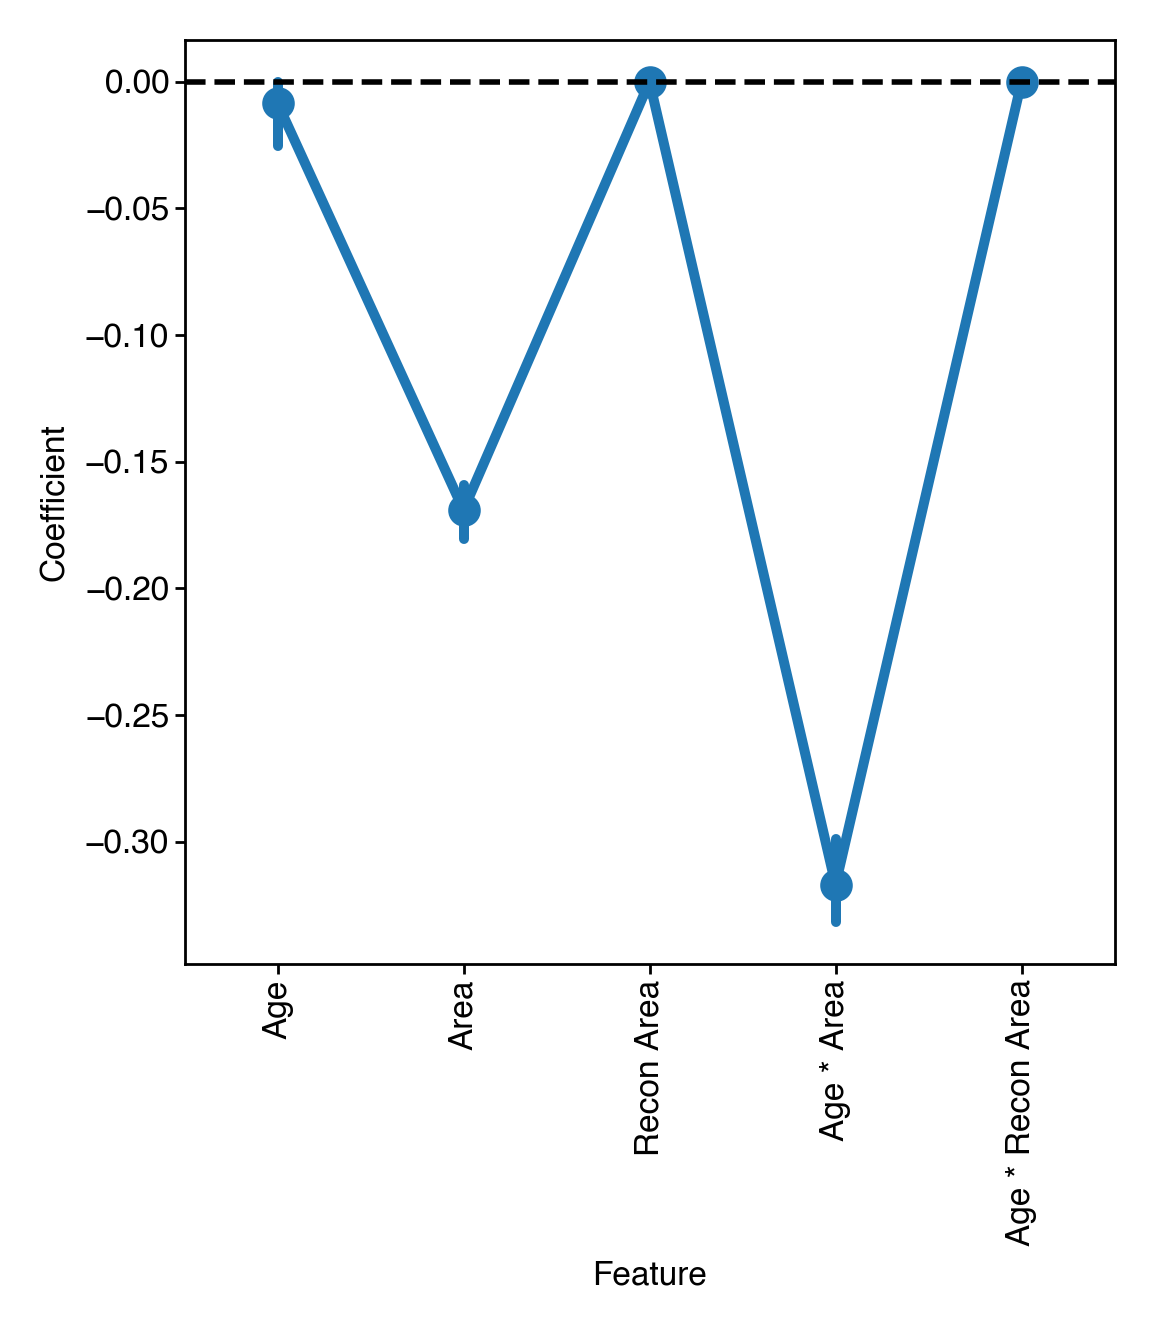

In [132]:
weights = np.array([est.named_steps['lasso'].coef_ for est in out['estimator']])
ax = sns.pointplot(weights)
ax.axhline(0, color='k', linestyle='--')
ax.set(ylabel="Coefficient", xlabel="Feature", xticklabels=['Age', 'Area', 'Recon Area', 'Age * Area', 'Age * Recon Area'])
plt.xticks(rotation=90)

In [134]:
X = out_df[['age', 'area']].to_numpy()
X = np.hstack([X, X[:, 0:1] * X[:, 1:2]])
Y = out_df['rear_counts']
Y = StandardScaler().fit_transform(Y.values.reshape(-1, 1)).ravel()
out = cross_validate(pipeline, X, Y, cv=shuffler, scoring='r2', return_estimator=True)
np.mean(out['test_score'])

0.3606334408730481

/tmp/ipykernel_12144/4271419284.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(ylabel="Coefficient", xlabel="Feature", xticklabels=['Age', 'Area', 'Age * Area'])


([0, 1, 2], [Text(0, 0, 'Age'), Text(1, 0, 'Area'), Text(2, 0, 'Age * Area')])

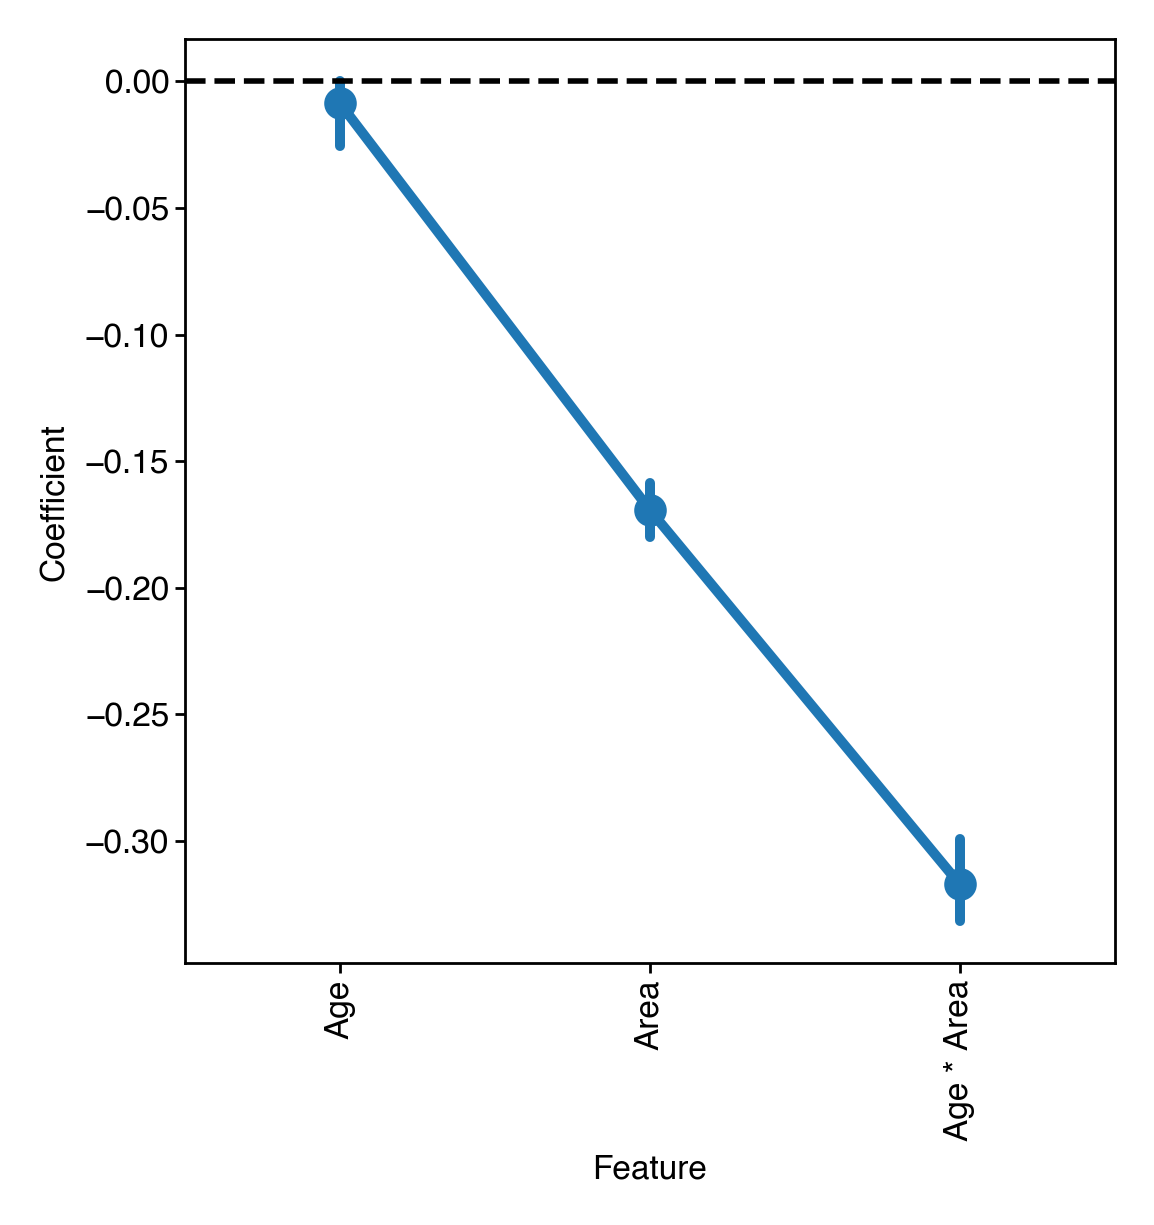

In [135]:
weights = np.array([est.named_steps['lasso'].coef_ for est in out['estimator']])
ax = sns.pointplot(weights)
ax.axhline(0, color='k', linestyle='--')
ax.set(ylabel="Coefficient", xlabel="Feature", xticklabels=['Age', 'Area', 'Age * Area'])
plt.xticks(rotation=90)